In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Read in the cleaned data fram, unprocessed (not tokenized etc)

In [2]:
df = pd.read_csv("df.csv")

In [3]:
df

,corpus,target
0,"""been feeling bad"" last 2 weeks & switched BP ...",N
1,"""can't walk"", reports onset at 0830 am. orient...",Y
2,"""dehydration"" Chest hurts, hips hurt, cramps P...",Y
3,"""gout flare up"" L arm swelling x 1 week. denie...",Y
4,"""heart racing,""dyspnea, and orthopnea that has...",N
...,...,...
8274,"stepped on a nail at home with right foot, pai...",N
8275,""" I was having a breakdown."" R/T stress and de...",N
8276,"""I tried to jump in front of a car"" Pt states ...",N
8277,Abdominal pain x 1 week. Denies PMH,N


### Select device to use for running model

In [4]:
# Currently using 'cpu' but keeping the 'cuda' for later updates
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Prepare data for tokenization

In [5]:
# Prepare corpus and target for tokenization
sentences = df.corpus.values
labels = df.target.values

# Bert requires special tokens at start and end of sentence
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

# Encode the 'target', changing from a string to an int
from sklearn.preprocessing import LabelEncoder 
label_encoder = LabelEncoder()

labels = label_encoder.fit_transform(labels)  # encode
labels = np.ravel(labels)                     # reshape
labels

array([0, 1, 1, ..., 0, 0, 0])

### Tokenize using BertTokenizer on a model called 'bert-base-uncased', a smaller, well-tested classification model

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', '"', 'been', 'feeling', 'bad', '"', 'last', '2', 'weeks', '&', 'switched', 'bp', 'medications', 'last', 'week', '&', 'worried', 'about', 'bp', 'pm', '##h', '##x', ':', 'ch', '##f', ',', 'h', '##t', '##n', ',', 'go', '##ut', ',', '3', 'strokes', ',', 'd', '##m', '[SEP]']


### Convert the tokens for Bert Classification Transformer

In [7]:
# Bert requires a token length be set, selecting a size larger then the max sentence length is common
MAX_LEN = 128

# Add padding to fill the token sentences
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

### Masks are created to prevent the model from 'cheating' during training

In [8]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

### Split data into train-validation sets including the masked data for use as 'inputs' into the BERT transformer

In [9]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

### Convert inputs to tensors

In [10]:

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

### Set the batch size.  Using this size, specify datasets to load into the training and validation epoch

In [11]:
# Set the batch size 
batch_size = 32 

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


### NOW the data is ready to go, it's tokenized, transformed, and loaded.  Below we create the Bert Classification transformer

In [12]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

### Below are potential parameters using to optimize the model

In [13]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


### Set the number of epochs to be run

In [14]:
epochs = 4

### Each epoch stores performance for plotting

In [15]:
# Store our loss and accuracy for plotting
train_loss_set = []

In [16]:
# Function to calculate the accuracy of our predictions vs target
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [17]:
# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /tmp/pip-req-build-kgsc5jd5/torch/csrc/utils/python_arg_parser.cpp:1005.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.09248618466495796


Epoch:  25%|██▌       | 1/4 [50:13<2:30:40, 3013.54s/it]

Validation Accuracy: 0.9867788461538461
Train loss: 0.0707435117811644


Epoch:  50%|█████     | 2/4 [1:40:29<1:40:29, 3014.82s/it]

Validation Accuracy: 0.9867788461538461
Train loss: 0.048105635109673306


Epoch:  75%|███████▌  | 3/4 [2:39:27<54:13, 3253.65s/it]  

Validation Accuracy: 0.9867788461538461
Train loss: 0.028650359375888976


Epoch: 100%|██████████| 4/4 [4:56:15<00:00, 4443.77s/it]

Validation Accuracy: 0.9867788461538461


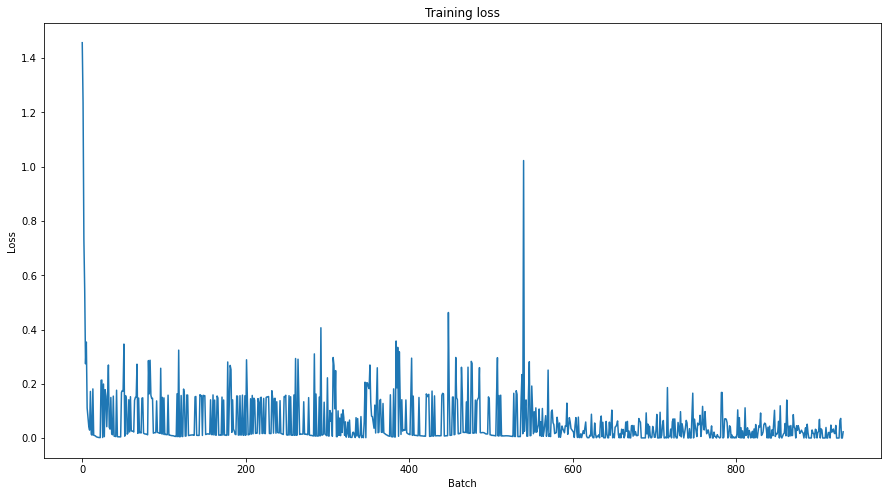

In [18]:
# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

*** From the graph above we see a small amount of noise.  The epoch of 4 does not improve accuracy.  Attempt another run with a smaller batch size to reduce noise and epoch of 2 to reduce unnessary time spent running the model ***

In [19]:
# Set the batch size 
batch_size = 16
epochs = 2

In [20]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [21]:
# Store our loss and accuracy for plotting
train_loss_set = []

In [22]:
# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))



Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.026148697721712938


Epoch:  50%|█████     | 1/2 [1:05:15<1:05:15, 3915.78s/it]

Validation Accuracy: 0.9867788461538461
Train loss: 0.026181237024088717


Epoch: 100%|██████████| 2/2 [5:36:35<00:00, 10097.72s/it] 

Validation Accuracy: 0.9867788461538461


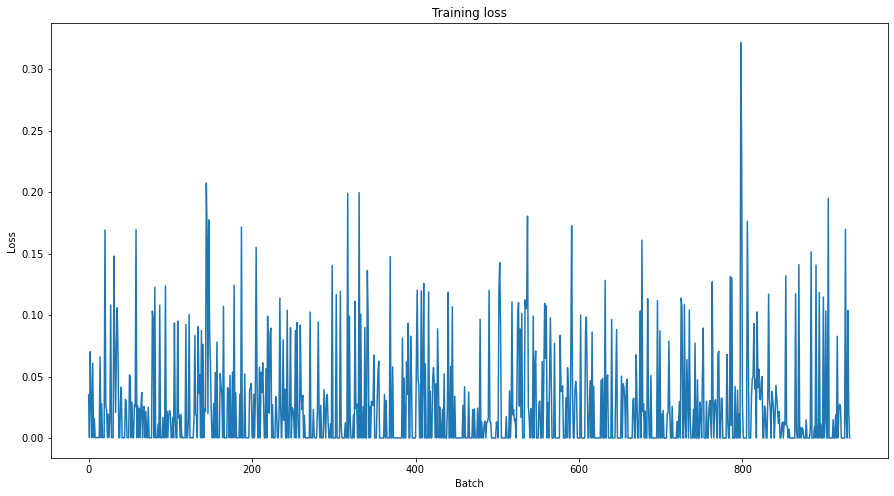

In [23]:
# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()